In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Notification priorities

**RQ:** What are the priority values for the unique notifications?

In [4]:
priority_map = {
    -2: 'PRIORITY_MIN',
    -1: 'PRIORITY_LOW',
    0:  'PRIORITY_DEFAULT',
    1:  'PRIORITY_HIGH',
    2:  'PRIORITY_MAX'
}

## Priorities per notification

In [5]:
def get_priority_values(lst):
    result = []
    for n in lst:
        priority = n['priority']
        priority = min(2, priority)
        priority = max(-2, priority)
        result.append({
            'PackageName': n['packageName'],
            'Id': n['key'] + '@' + str(n['postTime']),
            'Priority': priority
        })
    return result

def worker_priorities(uuid):        
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    
    result = df.Active.apply(get_priority_values).tolist()
    result = list(itertools.chain(*result))
    result = pd.DataFrame(result)
    result = result.groupby('Id', as_index=False).agg(list)
    result.Priority = result.Priority.apply(lambda x: x[-1])
    result.PackageName = result.PackageName.apply(lambda x: x[-1])
    
    result['UUID'] = uuid
    return result

In [6]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_priorities, uuids)

priority = pd.concat(lst)
priority = priority.reset_index(drop=True)
priority.tail()

,Id,PackageName,Priority,UUID
10928875,key.1437644@1541624736895,com.android.systemui,-2,device.3952
10928876,key.1437644@1541769638374,com.android.systemui,-2,device.3952
10928877,key.1437645@1541523629135,com.android.vending,-1,device.3952
10928878,key.1437645@1541696878386,com.android.vending,-1,device.3952
10928879,key.1437646@1541608219788,wp.wattpad,0,device.3952


In [7]:
len(priority.UUID.unique())

3953

In [8]:
len(priority)

10928880

## Priority stats

In [9]:
priority.Priority.value_counts(dropna=False).sort_index()

-2    1255475
-1     258295
 0    7006687
 1    1311672
 2    1096751
Name: Priority, dtype: int64

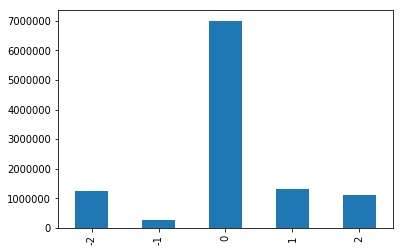

In [10]:
priority.Priority.value_counts().sort_index().plot(kind='bar')

## Add packages and categories

In [11]:
priority['Category'] = priority.PackageName.apply(lambda x: category_mapping[x] if x in category_mapping else 'UNKNOWN')
priority.tail()

,Id,PackageName,Priority,UUID,Category
10928875,key.1437644@1541624736895,com.android.systemui,-2,device.3952,SYSTEM
10928876,key.1437644@1541769638374,com.android.systemui,-2,device.3952,SYSTEM
10928877,key.1437645@1541523629135,com.android.vending,-1,device.3952,SYSTEM
10928878,key.1437645@1541696878386,com.android.vending,-1,device.3952,SYSTEM
10928879,key.1437646@1541608219788,wp.wattpad,0,device.3952,MEDIA


## Normalize

In [12]:
pnorm = priority.groupby(['UUID', 'Category'], as_index=False).agg(list)
pnorm.tail()

,UUID,Category,Id,PackageName,Priority
40620,device.3952,PHONE,"[key.1437635@1540931735258, key.1437635@154099...","[com.android.incallui, com.android.incallui, c...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
40621,device.3952,SMS/IM,"[key.1437629@1540812622930, key.1437629@154081...","[com.android.mms, com.android.mms, com.android...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40622,device.3952,SYSTEM,"[key.1437632@1540826017717, key.1437632@154082...","[com.android.systemui, com.android.systemui, c...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
40623,device.3952,TOOL,[key.1437639@1541081877577],[com.ttech.android.onlineislem],[1]
40624,device.3952,UNKNOWN,"[key.1437631@1540814415624, key.1437631@154133...","[package.6783, package.6783, package.6783, pac...","[0, 0, 0, 1, 0, 0, 0]"


In [13]:
pnorm['Min Priority']     = pnorm.Priority.apply(lambda x: x.count(-2) / len(x))
pnorm['Low Priority']     = pnorm.Priority.apply(lambda x: x.count(-1) / len(x))
pnorm['Default Priority'] = pnorm.Priority.apply(lambda x: x.count(0)  / len(x))
pnorm['High Priority']    = pnorm.Priority.apply(lambda x: x.count(1)  / len(x))
pnorm['Max Priority']     = pnorm.Priority.apply(lambda x: x.count(2)  / len(x))
pnorm.tail()

,UUID,Category,Id,PackageName,Priority,Min Priority,Low Priority,Default Priority,High Priority,Max Priority
40620,device.3952,PHONE,"[key.1437635@1540931735258, key.1437635@154099...","[com.android.incallui, com.android.incallui, c...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.000000,0.000000,0.250000,0.000000,0.750000
40621,device.3952,SMS/IM,"[key.1437629@1540812622930, key.1437629@154081...","[com.android.mms, com.android.mms, com.android...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,0.000000,1.000000,0.000000,0.000000
40622,device.3952,SYSTEM,"[key.1437632@1540826017717, key.1437632@154082...","[com.android.systemui, com.android.systemui, c...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.255319,0.042553,0.361702,0.021277,0.319149
40623,device.3952,TOOL,[key.1437639@1541081877577],[com.ttech.android.onlineislem],[1],0.000000,0.000000,0.000000,1.000000,0.000000
40624,device.3952,UNKNOWN,"[key.1437631@1540814415624, key.1437631@154133...","[package.6783, package.6783, package.6783, pac...","[0, 0, 0, 1, 0, 0, 0]",0.000000,0.000000,0.857143,0.142857,0.000000


## Plot

In [14]:
pnorm.Category = pnorm.Category.apply(str.title)
pnorm.Category = pnorm.Category.replace({
    'Shopping': 'Shopping & Fin.',
    'Calendar/Reminder': 'Cal. & Rem.',
    'Health/Fitness': 'Health & Fit.',
    'Sms/Im': 'SmS & IM', # Lowercase "m" to fix the sorting
    'Unknown': 'Uncategorized',
    'Social': 'Social & Dating',
    'News': 'News & Weather'
})

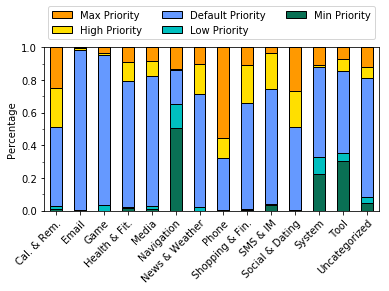

In [15]:
ax = pnorm.groupby('Category').mean().plot(
    kind='bar',
    stacked=True,
    grid=False,
    ylim=(0, 1),
    color=['#097054', '#00bfbf', '#6599ff', '#ffdf00', '#ff9900'],
    edgecolor='#000000',
    figsize=(6, 3)
)

# Dirty hack to fix the sorting
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[9] = 'SMS & IM'
ax.set_xticklabels(labels)

# Ticks
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticks(np.arange(0, 1.0, 0.1), minor=True)

# Tweak font sizes
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Percentage', fontsize=10)
ax.tick_params(labelsize=10)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=reversed(handles),
          labels=reversed(labels),
          loc='center',
          bbox_to_anchor=(0.5, 1.15),
          ncol=3, 
          prop={'size': 10})

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('figures/priorities.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/priorities.pdf', bbox_inches='tight', pad_inches=0)

plt.show()